# **_Importing Dependencies_**


In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.stem.porter import PorterStemmer
# from textblob import TextBlob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
import nltk
import re
import plotly.express as px

# Download necessary NLTK resources
MAIN_DIR = "/kaggle/working/"
try:
    nltk.download('wordnet', download_dir= MAIN_DIR + 'wordnet')
    nltk.download('stopwords', download_dir= MAIN_DIR + 'stopwords')
    nltk.download('punkt', download_dir= MAIN_DIR + 'punkt')

except Exception as e:
    print(f"Error downloading NLTK resources: {e}")


[nltk_data] Downloading package wordnet to /kaggle/working/wordnet...
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/stopwords...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/punkt...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **_Pre-Procession the Dataset..._**


In [2]:
# Step 1: Preprocessing functions
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', '<URL>', text)  # Replace URLs
    text = text.split()
    text = ' '.join(ps.stem(word) for word in text if word not in stop_words)  # Remove stop words
    # text = str(TextBlob(text).correct())  # Correct typos
    return text

# Step 2: Load and preprocess the dataset
CSV_FILE = "/kaggle/input/spam-sms-classification-using-nlp/Spam_SMS.csv"
dataset = pd.read_csv(CSV_FILE)
dataset['Message_cleaned'] = dataset['Message'].fillna('').apply(preprocess_text)
dataset['labels'] = dataset['Class'].apply(lambda x: 1 if x == 'spam' else 0)

# Load Dataset
data = pd.read_csv(CSV_FILE)
data = data.rename(columns={data.columns[0]: 'Class', data.columns[1]: 'Message'})
data = data[['Class', 'Message']]
data['Labels'] = data['Class'].map({'ham': 0, 'spam': 1})
data['Message_cleaned'] = data['Message'].apply(preprocess_text)

In [3]:
%pip install plotly
import plotly

Note: you may need to restart the kernel to use updated packages.


# **_Monitoring Class Imbalance_**


In [4]:
import plotly.graph_objects as go

label_counts = dataset['Class'].value_counts()

fig = go.Figure(data=[go.Pie(labels=label_counts.index, values=label_counts.values,
                              hoverinfo='label+percent', textinfo='value', textfont_size=20,
                              marker=dict(colors=['#66b3ff', '#ff6666']))])
fig.update_layout(title_text='Percentage of Ham and Spam Messages')
from IPython.display import display
display(fig)

In [5]:
%pip install gensim
import gensim.downloader as api

Note: you may need to restart the kernel to use updated packages.


**_Since the Class-Imbalance is severe, we will have to make the number of samples in each class (SPAM or HAM) relatively equal in number_**


In [6]:
spam_df = dataset[dataset['Class'] == 'spam']
spam_df

,Class,Message,Message_cleaned,labels
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win FA cup final tkt 21...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darl 3 week' word back! i'd like f...,1
8,spam,WINNER!! As a valued network customer you have...,winner!! As valu network custom select receive...,1
9,spam,Had your mobile 11 months or more? U R entitle...,had mobil 11 month more? U R entitl updat late...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...","six chanc win cash! from 100 20,000 pound txt>...",1
...,...,...,...,...
5539,spam,Want explicit SEX in 30 secs? Ring 02073162414...,want explicit sex 30 secs? ring 02073162414 no...,1
5542,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,ask 3mobil IF 0870 chatlin inclu IN free mins....,1
5549,spam,Had your contract mobile 11 Mnths? Latest Moto...,"had contract mobil 11 mnths? latest motorola, ...",1
5568,spam,REMINDER FROM O2: To get 2.50 pounds free call...,remind from o2: To get 2.50 pound free call cr...,1


In [7]:
ham_df = dataset[dataset['Class'] == 'ham']
ham_df

,Class,Message,Message_cleaned,labels
0,ham,"Go until jurong point, crazy.. Available only ...","Go jurong point, crazy.. avail bugi n great wo...",0
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...,0
3,ham,U dun say so early hor... U c already then say...,U dun say earli hor... U c alreadi say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I think goe usf, live around though",0
6,ham,Even my brother is not like to speak with me. ...,even brother like speak me. they treat like ai...,0
...,...,...,...,...
5567,ham,Huh y lei...,huh lei...,0
5570,ham,Will ü b going to esplanade fr home?,will ü b go esplanad fr home?,0
5571,ham,"Pity, * was in mood for that. So...any other s...","pity, * mood that. so...ani suggestions?",0
5572,ham,The guy did some bitching but I acted like i'd...,the guy bitch I act like i'd interest buy some...,0


In [8]:
dataset

,Class,Message,Message_cleaned,labels
0,ham,"Go until jurong point, crazy.. Available only ...","Go jurong point, crazy.. avail bugi n great wo...",0
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win FA cup final tkt 21...,1
3,ham,U dun say so early hor... U c already then say...,U dun say earli hor... U c alreadi say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I think goe usf, live around though",0
...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,thi 2nd time tri 2 contact u. U £750 pound pri...,1
5570,ham,Will ü b going to esplanade fr home?,will ü b go esplanad fr home?,0
5571,ham,"Pity, * was in mood for that. So...any other s...","pity, * mood that. so...ani suggestions?",0
5572,ham,The guy did some bitching but I acted like i'd...,the guy bitch I act like i'd interest buy some...,0


**_Splitting the Test-Set from the Train-Set prior to the Augmentation, so that original class proportion remains_**


In [9]:
# Seperating the Test dataset from the Main Dataset 
dataset, test_data = train_test_split(dataset,
                                      test_size = 0.05,
                                      stratify=dataset['Class'],
                                      random_state=42)

# **_Synthetically Augmenting Data_**


In [10]:
from sklearn.utils import resample
from imblearn.over_sampling import BorderlineSMOTE
from gensim.models import Word2Vec
import plotly.graph_objects as go
import plotly.colors

# Function 1: Train Word2Vec Model
def train_word2vec(df, vector_size=100, window=5, min_count=1, epochs=10):
    """
    Train a Word2Vec model using the Message_cleaned column.
    """
    sentences = df['Message_cleaned'].str.split().tolist()
    w2v_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=1)
    w2v_model.train(sentences, total_examples=len(sentences), epochs=epochs)
    return w2v_model

# Function 2: Vectorize Messages Using Word2Vec
def vectorize_message(message, model, vector_size):
    words = message.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Function 3: Convert Vectors to Synthetic Messages
def vectors_to_messages(vectors, model, top_n=5):
    synthetic_messages = []
    for vector in vectors:
        neighbors = model.wv.similar_by_vector(vector, topn=top_n)
        synthetic_message = " ".join([word for word, _ in neighbors])
        synthetic_messages.append(synthetic_message)
    return synthetic_messages

# Function 4: Balance Dataset with Synthetic Spam-Data and Down-Sampling Ham-Data
def balance_dataset_with_synthetic_spam(df, w2v_model, vector_size, target_ratio=0.5, num_synthetic_samples=None):
    """Balances dataset, generating synthetic spam if needed to reach target ratio.

    Args:
        df: Input DataFrame.
        w2v_model: Trained Word2Vec model.
        vector_size: Word2Vec vector size.
        target_ratio: Desired ratio of spam messages (spam / (spam + ham)).
        num_synthetic_samples: Number of samples to generate if target ratio can not be reached by downsampling alone.

    Returns:
        Balanced DataFrame.
    """
    spam_df = df[df['Class'] == 'spam']
    ham_df = df[df['Class'] == 'ham']

    n_spam = len(spam_df)
    n_ham = len(ham_df)
    
    # Calculate target number of ham messages
    target_n_ham = int(n_spam * (1 - target_ratio) / target_ratio)

    if target_n_ham < n_ham:
        # Downsample ham if there are too many
        n_ham_to_keep = target_n_ham
        ham_downsampled = resample(ham_df, replace=False, n_samples=n_ham_to_keep, random_state=42)
        balanced_df = pd.concat([spam_df, ham_downsampled]).reset_index(drop=True)
        synthetic_spam_df = pd.DataFrame()
        
    elif target_n_ham > n_ham:
        # Generate synthetic spam if there are too few
        n_spam_to_generate = int((target_ratio * (n_ham) / (1-target_ratio)) - n_spam)
        if num_synthetic_samples is not None:
             n_spam_to_generate = min(n_spam_to_generate, num_synthetic_samples)
        
        # Vectorize spam messages
        spam_vectors = np.array([vectorize_message(msg, w2v_model, vector_size) for msg in spam_df['Message_cleaned'] if isinstance(msg,str)])
        
        if len(spam_vectors) > 1:
            # Generate synthetic spam data using SMOTE-Borderline
            smote = BorderlineSMOTE()
            X_resampled, _ = smote.fit_resample(spam_vectors, np.ones(len(spam_vectors)))
            synthetic_vectors = X_resampled[len(spam_vectors):]  # Separate synthetic vectors
            
            # Convert synthetic vectors to synthetic messages
            synthetic_messages = vectors_to_messages(synthetic_vectors, w2v_model)
            synthetic_spam_df = pd.DataFrame({'Message_cleaned': synthetic_messages, 'Class': 'spam'})
            balanced_df = pd.concat([spam_df, ham_df, synthetic_spam_df]).reset_index(drop=True)

        else:
            balanced_df = pd.concat([spam_df, ham_df]).reset_index(drop=True)
            synthetic_spam_df = pd.DataFrame()
            print("Not enough spam messages to generate synthetic data.")

    else:
        #Dataset is already balanced
        balanced_df = pd.concat([spam_df, ham_df]).reset_index(drop=True)
        synthetic_spam_df = pd.DataFrame()

    return balanced_df

# Step 5: Train Word2Vec and Generate Final Dataset
# Train Word2Vec on the entire dataset
w2v_model = train_word2vec(dataset)

# Generate balanced dataset with synthetic spam
vector_size = w2v_model.vector_size
balanced_dataset = balance_dataset_with_synthetic_spam(dataset, w2v_model, vector_size, target_ratio=0.45)

# Convert "Class" column to binary labels
balanced_dataset['labels'] = balanced_dataset['Class'].apply(lambda x: 1 if x == 'spam' else 0)

# Final dataset shape
print(f"Final dataset shape: {balanced_dataset.shape}")
print(balanced_dataset['Class'].value_counts())

balanced_dataset

Final dataset shape: (1577, 4)
Class
ham     867
spam    710
Name: count, dtype: int64


,Class,Message,Message_cleaned,labels
0,spam,No. 1 Nokia Tone 4 ur mob every week! Just txt...,no. 1 nokia tone 4 ur mob everi week! just txt...,1
1,spam,U have a Secret Admirer who is looking 2 make ...,U secret admir look 2 make contact u-find r*re...,1
2,spam,Last Chance! Claim ur £150 worth of discount v...,last chance! claim ur £150 worth discount vouc...,1
3,spam,Free Top ringtone -sub to weekly ringtone-get ...,free top rington -sub weekli ringtone-get 1st ...,1
4,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,hot live fantasi call 08707509020 just 20p per...,1
...,...,...,...,...
1572,ham,Well i know Z will take care of me. So no worr...,well know Z take care me. So worries.,0
1573,ham,"Hi frnd, which is best way to avoid missunders...","Hi frnd, best way avoid missunderstd wit belov...",0
1574,ham,Hey no I ad a crap nite was borin without ya 2...,hey I ad crap nite borin without ya 2 boggi u ...,0
1575,ham,Hey i booked the kb on sat already... what oth...,hey book kb sat already... lesson go ah? keep ...,0


In [11]:
balanced_dataset.drop(columns="Message", inplace=True)
balanced_dataset['labels'] = balanced_dataset['Class'].apply(lambda x: 1 if x == 'spam' else 0)

balanced_dataset

,Class,Message_cleaned,labels
0,spam,no. 1 nokia tone 4 ur mob everi week! just txt...,1
1,spam,U secret admir look 2 make contact u-find r*re...,1
2,spam,last chance! claim ur £150 worth discount vouc...,1
3,spam,free top rington -sub weekli ringtone-get 1st ...,1
4,spam,hot live fantasi call 08707509020 just 20p per...,1
...,...,...,...
1572,ham,well know Z take care me. So worries.,0
1573,ham,"Hi frnd, best way avoid missunderstd wit belov...",0
1574,ham,hey I ad crap nite borin without ya 2 boggi u ...,0
1575,ham,hey book kb sat already... lesson go ah? keep ...,0


# **_Checking the Class Imbalance now...._**


In [12]:
dataset = balanced_dataset
label_counts = dataset['Class'].value_counts()

fig = go.Figure(data=[go.Pie(labels=label_counts.index, values=label_counts.values,
                              hoverinfo='label+percent', textinfo='value', textfont_size=20,
                              marker=dict(colors=['#66b3ff', '#ff6666']))])
fig.update_layout(title_text='Percentage of Ham and Spam Messages')
display(fig)

In [13]:
dataset['Class'].value_counts()

Class
ham     867
spam    710
Name: count, dtype: int64

# **_Splitting the Dataset into Training ... Validation ... Test Datasets_**


In [14]:
# Train-test-validation split
train_data, val_data = train_test_split(dataset,
                                         test_size=0.10,
                                         stratify=dataset['Class'],
                                         random_state=42)

# Custom Dataset Class
class SMSDataset(Dataset):
    def __init__(self, data, w2v_model):  # Add w2v_model and vector_size as arguments
        self.messages = data['Message_cleaned'].values
        self.labels = data['Class'].apply(lambda x: 1 if x == 'spam' else 0).values
        self.w2v_model = w2v_model  # Store the Word2Vec model
        self.vector_size = w2v_model.vector_size # Store the vector size

    def __len__(self):
        return len(self.messages)

    def __getitem__(self, idx):
        message = self.messages[idx]
        label = self.labels[idx]

        # Handle potential NaN values or non-string messages
        if not isinstance(message, str):
            vectorized_message = np.zeros(self.vector_size) # Or handle it differently as needed
        else:
            vectorized_message = vectorize_message(message, self.w2v_model, self.vector_size)

        return torch.tensor(vectorized_message, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

print(SMSDataset)

<class '__main__.SMSDataset'>


In [15]:
# Viewing the Training Data 
train_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
train_data.drop(columns="Message", inplace=True)

train_data['Class'].value_counts()

Class
ham     1022
spam     676
Name: count, dtype: int64

In [16]:
# Creating Datasets and DataLoaders
train_dataset = SMSDataset(train_data, w2v_model)
val_dataset = SMSDataset(val_data, w2v_model)
test_dataset = SMSDataset(test_data, w2v_model)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **_Custom LR Scheduler_**


In [17]:
class CustomLRScheduler:
    def __init__(self, optimizer, patience=3, cooldown=7, reduction_factor=0.5, increase_factor=2, min_lr=1e-6, base_lr=1e-4):
        """
        Custom learning rate scheduler.
        
        Args:
            optimizer (torch.optim.Optimizer): Optimizer instance.
            patience (int): Number of epochs to wait for improvement.
            cooldown (int): Number of epochs to increase LR after no significant change.
            reduction_factor (float): Factor to reduce LR when metrics stagnate.
            increase_factor (float): Factor to increase LR after cooldown period.
            min_lr (float): Minimum allowable learning rate.
            base_lr (float): Original learning rate.
        """
        self.optimizer = optimizer
        self.patience = patience
        self.cooldown = cooldown
        self.reduction_factor = reduction_factor
        self.increase_factor = increase_factor
        self.min_lr = min_lr
        self.base_lr = base_lr

        # State variables
        self.no_improvement_count = 0
        self.epoch_count = 0
        self.current_lr = base_lr
        self.best_metrics = {"train_loss": float("inf"), "val_loss": float("inf"), "val_acc": 0}
        self.last_action = None

    def step(self, train_loss, val_loss, val_acc):
        metrics = {"train_loss": train_loss, "val_loss": val_loss, "val_acc": val_acc}
        improved = False

        # Check if any metric has improved
        for key in self.best_metrics:
            if key == "val_acc":
                if metrics[key] > self.best_metrics[key]:  # Accuracy should increase
                    self.best_metrics[key] = metrics[key]
                    improved = True
            else:
                if metrics[key] < self.best_metrics[key]:  # Losses should decrease
                    self.best_metrics[key] = metrics[key]
                    improved = True

        if improved:
            # Revert to base LR on improvement
            self.no_improvement_count = 0
            if self.current_lr != self.base_lr:
                self.set_lr(self.base_lr)
                self.last_action = "Reverted to base LR due to improvement."
        else:
            # No improvement
            self.no_improvement_count += 1
            self.epoch_count += 1

            # Reduce LR if patience is exceeded
            if self.no_improvement_count >= self.patience:
                new_lr = max(self.current_lr * self.reduction_factor, self.min_lr)
                if new_lr < self.current_lr:
                    self.set_lr(new_lr)
                    self.last_action = f"Reduced LR to {new_lr:.6f} after no improvement for {self.patience} epochs."
                self.no_improvement_count = 0

            # Double LR after cooldown period
            if self.epoch_count % self.cooldown == 0:
                new_lr = min(self.base_lr * self.increase_factor, self.base_lr)
                if new_lr > self.current_lr:
                    self.set_lr(new_lr)
                    self.last_action = f"Doubled LR to {new_lr:.6f} after {self.cooldown} epochs."
    # Set the learning rate for all parameter groups. 
    def set_lr(self, new_lr):

        for param_group in self.optimizer.param_groups:
            param_group["lr"] = new_lr
        self.current_lr = new_lr
    
    #  Get a description of the last action performed by the scheduler.
    def get_last_action(self):
        return self.last_action

# **_Helper Functions to plot Interactive Graphs_**


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Seaborn and Matplotlib Plot
def plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses,
                 train_f1_scores, val_f1_scores, train_precisions, val_precisions,
                 interactive=True):  # Toggle for interactive Plotly plots

    if interactive:
        # Plotly Implementation for Interactive Plots
        fig = go.Figure()

        # Accuracy
        fig.add_trace(go.Scatter(x=list(range(len(train_accuracies))),
                                 y=train_accuracies,
                                 mode='lines+markers',
                                 name='Train Accuracy',
                                 line=dict(width=2, color='blue')))
        fig.add_trace(go.Scatter(x=list(range(len(val_accuracies))),
                                 y=val_accuracies,
                                 mode='lines+markers',
                                 name='Validation Accuracy',
                                 line=dict(width=2, color='orange')))

        # Loss
        fig.add_trace(go.Scatter(x=list(range(len(train_losses))),
                                 y=train_losses,
                                 mode='lines+markers',
                                 name='Train Loss',
                                 line=dict(width=2, color='green')))
        fig.add_trace(go.Scatter(x=list(range(len(val_losses))),
                                 y=val_losses,
                                 mode='lines+markers',
                                 name='Validation Loss',
                                 line=dict(width=2, color='red')))

        # F1-Score
        fig.add_trace(go.Scatter(x=list(range(len(train_f1_scores))),
                                 y=train_f1_scores,
                                 mode='lines+markers',
                                 name='Train F1-Score',
                                 line=dict(width=2, color='purple')))
        fig.add_trace(go.Scatter(x=list(range(len(val_f1_scores))),
                                 y=val_f1_scores,
                                 mode='lines+markers',
                                 name='Validation F1-Score',
                                 line=dict(width=2, color='brown')))

        # Precision
        fig.add_trace(go.Scatter(x=list(range(len(train_precisions))),
                                 y=train_precisions,
                                 mode='lines+markers',
                                 name='Train Precision',
                                 line=dict(width=2, color='cyan')))
        fig.add_trace(go.Scatter(x=list(range(len(val_precisions))),
                                 y=val_precisions,
                                 mode='lines+markers',
                                 name='Validation Precision',
                                 line=dict(width=2, color='magenta')))

        # Layout
        fig.update_layout(title="Model Performance Metrics",
                          xaxis_title="Epochs",
                          yaxis_title="Metrics Value",
                          legend_title="Metrics",
                          template="plotly_white",
                          width=900,
                          height=600)
        fig.show()

    else:
        # Static Plot with Seaborn and Matplotlib
        sns.set_theme(style="whitegrid", palette="muted")

        # Create a figure with a grid layout
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('LSTM Model Performance Metrics', fontsize=18, fontweight='bold')

        # Plot accuracy
        sns.lineplot(ax=axes[0, 0], x=range(len(train_accuracies)), y=train_accuracies, label='Train Accuracy',
                     linewidth=2, marker='o', color='blue')
        sns.lineplot(ax=axes[0, 0], x=range(len(val_accuracies)), y=val_accuracies, label='Validation Accuracy',
                     linewidth=2, marker='s', color='orange')
        axes[0, 0].set_title('Accuracy', fontsize=14)
        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Accuracy', fontsize=12)
        axes[0, 0].legend()

        # Plot loss
        sns.lineplot(ax=axes[0, 1], x=range(len(train_losses)), y=train_losses, label='Train Loss',
                     linewidth=2, marker='o', color='green')
        sns.lineplot(ax=axes[0, 1], x=range(len(val_losses)), y=val_losses, label='Validation Loss',
                     linewidth=2, marker='s', color='red')
        axes[0, 1].set_title('Loss', fontsize=14)
        axes[0, 1].set_xlabel('Epoch', fontsize=12)
        axes[0, 1].set_ylabel('Loss', fontsize=12)
        axes[0, 1].legend()

        # Plot F1-Score
        sns.lineplot(ax=axes[1, 0], x=range(len(train_f1_scores)), y=train_f1_scores, label='Train F1-Score',
                     linewidth=2, marker='o', color='purple')
        sns.lineplot(ax=axes[1, 0], x=range(len(val_f1_scores)), y=val_f1_scores, label='Validation F1-Score',
                     linewidth=2, marker='s', color='brown')
        axes[1, 0].set_title('F1-Score', fontsize=14)
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('F1-Score', fontsize=12)
        axes[1, 0].legend()

        # Plot precision
        sns.lineplot(ax=axes[1, 1], x=range(len(train_precisions)), y=train_precisions, label='Train Precision',
                     linewidth=2, marker='o', color='cyan')
        sns.lineplot(ax=axes[1, 1], x=range(len(val_precisions)), y=val_precisions, label='Validation Precision',
                     linewidth=2, marker='s', color='magenta')
        axes[1, 1].set_title('Precision', fontsize=14)
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Precision', fontsize=12)
        axes[1, 1].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for title space
        plt.show()


# **_Bidirectional LSTM for Training on the Augmented-Messages_**


In [19]:
import tqdm
from sklearn.metrics import f1_score, precision_score

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, bidirectional=True, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Add sequence dimension
        x = x.unsqueeze(1)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_dim).to(x.device)

        # LSTM forward pass
        out, (hidden, _) = self.lstm(x, (h0, c0))

        # Use the last hidden state
        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)  # Concatenate forward and backward hidden states
        else:
            hidden = hidden[-1]

        # Fully connected layer
        out = self.fc(self.dropout(hidden))
        return out


# **_Let the Training Begin..._**


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score
import tqdm
from sklearn.metrics import completeness_score, ConfusionMatrixDisplay


# Hyper-Parameters
input_dim = 100
hidden_dim = 128
output_dim = 1
num_epochs = 300
learning_rate = 0.0001


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []

# To store the best model state dictionary
# best_val_accuracy = 0.0
# best_model = LSTMModel(input_dim, hidden_dim, output_dim).cuda()
model = LSTMModel(input_dim, hidden_dim, output_dim).cuda()

def train_lstm(train_loader, val_loader, input_dim, hidden_dim, output_dim, num_epochs=50, learning_rate=0.0001):
    # Initialize model, loss, optimizer, and custom scheduler
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = CustomLRScheduler(optimizer, patience=3, cooldown=7, base_lr=learning_rate, min_lr=1e-6)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []
    train_precisions, val_precisions = [], []

    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss, correct_train_preds, total_train_samples = 0, 0, 0
        train_preds_all, train_labels_all = [], []

        total_val_loss, correct_val_preds, total_val_samples = 0, 0, 0
        val_preds_all, val_labels_all = [], []

        train_batches = iter(train_loader)
        val_batches = iter(val_loader)

        # best_val_accuracy = 0.0
        
        with tqdm.tqdm(range(len(train_loader)), desc=f"Epoch {epoch + 1}/{num_epochs}") as trainer:
            for step in trainer:
                # Training Loop
                try:
                    features, labels = next(train_batches)
                    features, labels = features.cuda(), labels.float().cuda()
                    optimizer.zero_grad()
                    outputs = model(features)

                    # Calculate loss and backpropagate
                    loss = criterion(outputs.squeeze(), labels)
                    loss.backward()
                    optimizer.step()

                    # Track training loss and accuracy
                    total_train_loss += loss.item()
                    preds = torch.round(torch.sigmoid(outputs))
                    correct_train_preds += (preds.squeeze() == labels).sum().item()
                    total_train_samples += labels.size(0)

                    # Store predictions and labels for metrics calculation
                    train_preds_all.extend(preds.cpu().detach().numpy())
                    train_labels_all.extend(labels.cpu().numpy())
                except StopIteration:
                    pass

                # Validation Loop for every 5 training batches
                if step % 5 == 0:
                    model.eval()
                    with torch.no_grad():
                        try:
                            val_features, val_labels = next(val_batches)
                            val_features, val_labels = val_features.cuda(), val_labels.float().cuda()
                            val_outputs = model(val_features)

                            # Loss calculation
                            val_loss = criterion(val_outputs.squeeze(), val_labels)
                            total_val_loss += val_loss.item()

                            val_preds = torch.round(torch.sigmoid(val_outputs))
                            correct_val_preds += (val_preds.squeeze() == val_labels).sum().item()
                            total_val_samples += val_labels.size(0)

                            # Collect predictions and labels for metrics
                            val_preds_all.extend(val_preds.cpu().detach().numpy())
                            val_labels_all.extend(val_labels.cpu().numpy())
                        except StopIteration:
                            pass
                    model.train()

                trainer.set_postfix(loss=total_train_loss / (step + 1),
                                    accuracy=correct_train_preds / total_train_samples)

        # Training Metrics
        train_accuracy = correct_train_preds / total_train_samples
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation Metrics
        val_accuracy = correct_val_preds / total_val_samples if total_val_samples > 0 else 0
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     best_model = model.copy()  # Create a deep copy of the current model
            
        # Print Epoch Metrics
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

        # Step the custom scheduler
        scheduler.step(train_losses[-1], val_losses[-1], val_accuracies[-1])

        print(f"Scheduler action: {scheduler.get_last_action()}")

        # Calculate and display confusion matrix for validation set after all data processed
        # if val_preds_all and val_labels_all:
        #     cm = confusion_matrix(val_labels_all, val_preds_all)
        #     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        #     disp.plot(cmap="viridis")
        #     plt.title(f"Confusion Matrix for Epoch {epoch + 1}")
        #     plt.show()

# Save the Best Model State
# MODEL_PTH = "/kaggle/working/best_lstm_model"
# torch.save(best_model.state_dict(), MODEL_PTH)
# print("=" * 80)
# print("Best model saved with Validation Accuracy:", best_val_accuracy)
            
        # Interactive plot (Plotly)
        plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses,
                     train_f1_scores, val_f1_scores, train_precisions, val_precisions)

train_lstm(train_loader, val_loader, input_dim, hidden_dim, output_dim, num_epochs, learning_rate)

Epoch 1/300: 100%|██████████| 54/54 [00:01<00:00, 38.83it/s, accuracy=0.602, loss=0.686]


Epoch 1/300, Train Loss: 0.6859, Train Accuracy: 0.6025, Val Loss: 0.6910, Val Accuracy: 0.5506
Scheduler action: None


Epoch 2/300: 100%|██████████| 54/54 [00:00<00:00, 94.97it/s, accuracy=0.602, loss=0.672]


Epoch 2/300, Train Loss: 0.6716, Train Accuracy: 0.6019, Val Loss: 0.6838, Val Accuracy: 0.5506
Scheduler action: None


Epoch 3/300: 100%|██████████| 54/54 [00:00<00:00, 98.90it/s, accuracy=0.637, loss=0.579] 


Epoch 3/300, Train Loss: 0.5794, Train Accuracy: 0.6372, Val Loss: 0.6390, Val Accuracy: 0.5506
Scheduler action: None


Epoch 4/300: 100%|██████████| 54/54 [00:00<00:00, 96.80it/s, accuracy=0.87, loss=0.363] 


Epoch 4/300, Train Loss: 0.3629, Train Accuracy: 0.8704, Val Loss: 0.4291, Val Accuracy: 0.8291
Scheduler action: None


Epoch 5/300: 100%|██████████| 54/54 [00:00<00:00, 97.84it/s, accuracy=0.941, loss=0.224]


Epoch 5/300, Train Loss: 0.2235, Train Accuracy: 0.9411, Val Loss: 0.2536, Val Accuracy: 0.9557
Scheduler action: None


Epoch 6/300: 100%|██████████| 54/54 [00:00<00:00, 97.18it/s, accuracy=0.945, loss=0.164]


Epoch 6/300, Train Loss: 0.1641, Train Accuracy: 0.9452, Val Loss: 0.1754, Val Accuracy: 0.9557
Scheduler action: None


Epoch 7/300: 100%|██████████| 54/54 [00:00<00:00, 97.24it/s, accuracy=0.945, loss=0.146]


Epoch 7/300, Train Loss: 0.1456, Train Accuracy: 0.9452, Val Loss: 0.1437, Val Accuracy: 0.9557
Scheduler action: None


Epoch 8/300: 100%|██████████| 54/54 [00:00<00:00, 98.37it/s, accuracy=0.947, loss=0.139]


Epoch 8/300, Train Loss: 0.1389, Train Accuracy: 0.9470, Val Loss: 0.1322, Val Accuracy: 0.9557
Scheduler action: None


Epoch 9/300: 100%|██████████| 54/54 [00:00<00:00, 100.44it/s, accuracy=0.946, loss=0.135]


Epoch 9/300, Train Loss: 0.1348, Train Accuracy: 0.9464, Val Loss: 0.1258, Val Accuracy: 0.9557
Scheduler action: None


Epoch 10/300: 100%|██████████| 54/54 [00:00<00:00, 100.74it/s, accuracy=0.948, loss=0.136]


Epoch 10/300, Train Loss: 0.1356, Train Accuracy: 0.9476, Val Loss: 0.1230, Val Accuracy: 0.9557
Scheduler action: None


Epoch 11/300: 100%|██████████| 54/54 [00:00<00:00, 100.47it/s, accuracy=0.947, loss=0.131]


Epoch 11/300, Train Loss: 0.1313, Train Accuracy: 0.9470, Val Loss: 0.1194, Val Accuracy: 0.9557
Scheduler action: None


Epoch 12/300: 100%|██████████| 54/54 [00:00<00:00, 98.28it/s, accuracy=0.949, loss=0.128]


Epoch 12/300, Train Loss: 0.1284, Train Accuracy: 0.9494, Val Loss: 0.1177, Val Accuracy: 0.9557
Scheduler action: None


Epoch 13/300: 100%|██████████| 54/54 [00:00<00:00, 89.30it/s, accuracy=0.945, loss=0.131]


Epoch 13/300, Train Loss: 0.1310, Train Accuracy: 0.9452, Val Loss: 0.1157, Val Accuracy: 0.9620
Scheduler action: None


Epoch 14/300: 100%|██████████| 54/54 [00:00<00:00, 85.64it/s, accuracy=0.952, loss=0.127]


Epoch 14/300, Train Loss: 0.1267, Train Accuracy: 0.9523, Val Loss: 0.1151, Val Accuracy: 0.9557
Scheduler action: None


Epoch 15/300: 100%|██████████| 54/54 [00:00<00:00, 81.45it/s, accuracy=0.949, loss=0.126]


Epoch 15/300, Train Loss: 0.1258, Train Accuracy: 0.9494, Val Loss: 0.1134, Val Accuracy: 0.9620
Scheduler action: None


Epoch 16/300: 100%|██████████| 54/54 [00:00<00:00, 95.35it/s, accuracy=0.952, loss=0.125]


Epoch 16/300, Train Loss: 0.1254, Train Accuracy: 0.9517, Val Loss: 0.1130, Val Accuracy: 0.9684
Scheduler action: None


Epoch 17/300: 100%|██████████| 54/54 [00:00<00:00, 97.72it/s, accuracy=0.951, loss=0.123] 


Epoch 17/300, Train Loss: 0.1227, Train Accuracy: 0.9511, Val Loss: 0.1114, Val Accuracy: 0.9684
Scheduler action: None


Epoch 18/300: 100%|██████████| 54/54 [00:00<00:00, 91.85it/s, accuracy=0.948, loss=0.124]


Epoch 18/300, Train Loss: 0.1244, Train Accuracy: 0.9482, Val Loss: 0.1113, Val Accuracy: 0.9684
Scheduler action: None


Epoch 19/300: 100%|██████████| 54/54 [00:00<00:00, 98.57it/s, accuracy=0.953, loss=0.123]


Epoch 19/300, Train Loss: 0.1230, Train Accuracy: 0.9529, Val Loss: 0.1109, Val Accuracy: 0.9684
Scheduler action: None


Epoch 20/300: 100%|██████████| 54/54 [00:00<00:00, 96.96it/s, accuracy=0.952, loss=0.122]


Epoch 20/300, Train Loss: 0.1223, Train Accuracy: 0.9523, Val Loss: 0.1109, Val Accuracy: 0.9684
Scheduler action: None


Epoch 21/300: 100%|██████████| 54/54 [00:00<00:00, 97.99it/s, accuracy=0.951, loss=0.122]


Epoch 21/300, Train Loss: 0.1224, Train Accuracy: 0.9511, Val Loss: 0.1098, Val Accuracy: 0.9684
Scheduler action: None


Epoch 22/300: 100%|██████████| 54/54 [00:00<00:00, 98.70it/s, accuracy=0.953, loss=0.123] 


Epoch 22/300, Train Loss: 0.1225, Train Accuracy: 0.9535, Val Loss: 0.1092, Val Accuracy: 0.9684
Scheduler action: None


Epoch 23/300: 100%|██████████| 54/54 [00:00<00:00, 98.27it/s, accuracy=0.952, loss=0.123]


Epoch 23/300, Train Loss: 0.1232, Train Accuracy: 0.9517, Val Loss: 0.1097, Val Accuracy: 0.9684
Scheduler action: None


Epoch 24/300: 100%|██████████| 54/54 [00:00<00:00, 97.98it/s, accuracy=0.951, loss=0.125] 


Epoch 24/300, Train Loss: 0.1246, Train Accuracy: 0.9511, Val Loss: 0.1091, Val Accuracy: 0.9684
Scheduler action: None


Epoch 25/300: 100%|██████████| 54/54 [00:00<00:00, 99.39it/s, accuracy=0.952, loss=0.122] 


Epoch 25/300, Train Loss: 0.1216, Train Accuracy: 0.9523, Val Loss: 0.1085, Val Accuracy: 0.9684
Scheduler action: None


Epoch 26/300: 100%|██████████| 54/54 [00:00<00:00, 96.10it/s, accuracy=0.951, loss=0.122]


Epoch 26/300, Train Loss: 0.1224, Train Accuracy: 0.9511, Val Loss: 0.1082, Val Accuracy: 0.9684
Scheduler action: None


Epoch 27/300: 100%|██████████| 54/54 [00:00<00:00, 95.23it/s, accuracy=0.952, loss=0.118]


Epoch 27/300, Train Loss: 0.1182, Train Accuracy: 0.9523, Val Loss: 0.1077, Val Accuracy: 0.9684
Scheduler action: None


Epoch 28/300: 100%|██████████| 54/54 [00:00<00:00, 96.41it/s, accuracy=0.954, loss=0.134]


Epoch 28/300, Train Loss: 0.1342, Train Accuracy: 0.9541, Val Loss: 0.1081, Val Accuracy: 0.9684
Scheduler action: None


Epoch 29/300: 100%|██████████| 54/54 [00:00<00:00, 92.76it/s, accuracy=0.951, loss=0.121]


Epoch 29/300, Train Loss: 0.1210, Train Accuracy: 0.9505, Val Loss: 0.1090, Val Accuracy: 0.9620
Scheduler action: None


Epoch 30/300: 100%|██████████| 54/54 [00:00<00:00, 94.57it/s, accuracy=0.952, loss=0.128]


Epoch 30/300, Train Loss: 0.1282, Train Accuracy: 0.9523, Val Loss: 0.1080, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 31/300: 100%|██████████| 54/54 [00:00<00:00, 97.37it/s, accuracy=0.957, loss=0.117]


Epoch 31/300, Train Loss: 0.1169, Train Accuracy: 0.9570, Val Loss: 0.1074, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 32/300: 100%|██████████| 54/54 [00:00<00:00, 95.95it/s, accuracy=0.953, loss=0.132]


Epoch 32/300, Train Loss: 0.1321, Train Accuracy: 0.9535, Val Loss: 0.1074, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 33/300: 100%|██████████| 54/54 [00:00<00:00, 97.44it/s, accuracy=0.952, loss=0.12] 


Epoch 33/300, Train Loss: 0.1197, Train Accuracy: 0.9523, Val Loss: 0.1087, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 34/300: 100%|██████████| 54/54 [00:00<00:00, 98.03it/s, accuracy=0.956, loss=0.118] 


Epoch 34/300, Train Loss: 0.1180, Train Accuracy: 0.9564, Val Loss: 0.1075, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 35/300: 100%|██████████| 54/54 [00:00<00:00, 92.65it/s, accuracy=0.955, loss=0.119]


Epoch 35/300, Train Loss: 0.1192, Train Accuracy: 0.9552, Val Loss: 0.1072, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 36/300: 100%|██████████| 54/54 [00:00<00:00, 97.47it/s, accuracy=0.952, loss=0.126] 


Epoch 36/300, Train Loss: 0.1261, Train Accuracy: 0.9523, Val Loss: 0.1068, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 37/300: 100%|██████████| 54/54 [00:00<00:00, 98.24it/s, accuracy=0.953, loss=0.119] 


Epoch 37/300, Train Loss: 0.1186, Train Accuracy: 0.9529, Val Loss: 0.1084, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 38/300: 100%|██████████| 54/54 [00:00<00:00, 98.37it/s, accuracy=0.957, loss=0.118]


Epoch 38/300, Train Loss: 0.1183, Train Accuracy: 0.9570, Val Loss: 0.1069, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 39/300: 100%|██████████| 54/54 [00:00<00:00, 98.36it/s, accuracy=0.955, loss=0.115] 


Epoch 39/300, Train Loss: 0.1155, Train Accuracy: 0.9552, Val Loss: 0.1065, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 40/300: 100%|██████████| 54/54 [00:00<00:00, 100.66it/s, accuracy=0.955, loss=0.124]


Epoch 40/300, Train Loss: 0.1239, Train Accuracy: 0.9547, Val Loss: 0.1063, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 41/300: 100%|██████████| 54/54 [00:00<00:00, 99.45it/s, accuracy=0.957, loss=0.116] 

Epoch 41/300, Train Loss: 0.1156, Train Accuracy: 0.9570, Val Loss: 0.1062, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 42/300: 100%|██████████| 54/54 [00:00<00:00, 97.95it/s, accuracy=0.951, loss=0.118]


Epoch 42/300, Train Loss: 0.1182, Train Accuracy: 0.9505, Val Loss: 0.1062, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 43/300: 100%|██████████| 54/54 [00:00<00:00, 99.07it/s, accuracy=0.958, loss=0.115]


Epoch 43/300, Train Loss: 0.1154, Train Accuracy: 0.9582, Val Loss: 0.1061, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 44/300: 100%|██████████| 54/54 [00:00<00:00, 97.70it/s, accuracy=0.956, loss=0.12] 


Epoch 44/300, Train Loss: 0.1203, Train Accuracy: 0.9558, Val Loss: 0.1054, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 45/300: 100%|██████████| 54/54 [00:00<00:00, 99.03it/s, accuracy=0.955, loss=0.119] 


Epoch 45/300, Train Loss: 0.1189, Train Accuracy: 0.9547, Val Loss: 0.1053, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 46/300: 100%|██████████| 54/54 [00:00<00:00, 99.07it/s, accuracy=0.955, loss=0.115] 


Epoch 46/300, Train Loss: 0.1148, Train Accuracy: 0.9552, Val Loss: 0.1054, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 47/300: 100%|██████████| 54/54 [00:00<00:00, 99.84it/s, accuracy=0.956, loss=0.12]  


Epoch 47/300, Train Loss: 0.1205, Train Accuracy: 0.9564, Val Loss: 0.1055, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 48/300: 100%|██████████| 54/54 [00:00<00:00, 98.33it/s, accuracy=0.953, loss=0.117] 


Epoch 48/300, Train Loss: 0.1169, Train Accuracy: 0.9535, Val Loss: 0.1050, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 49/300: 100%|██████████| 54/54 [00:00<00:00, 100.45it/s, accuracy=0.953, loss=0.118]


Epoch 49/300, Train Loss: 0.1176, Train Accuracy: 0.9535, Val Loss: 0.1050, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 50/300: 100%|██████████| 54/54 [00:00<00:00, 99.32it/s, accuracy=0.953, loss=0.116] 


Epoch 50/300, Train Loss: 0.1155, Train Accuracy: 0.9529, Val Loss: 0.1051, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 51/300: 100%|██████████| 54/54 [00:00<00:00, 99.79it/s, accuracy=0.956, loss=0.117] 


Epoch 51/300, Train Loss: 0.1172, Train Accuracy: 0.9564, Val Loss: 0.1047, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 52/300: 100%|██████████| 54/54 [00:00<00:00, 91.12it/s, accuracy=0.955, loss=0.115]


Epoch 52/300, Train Loss: 0.1153, Train Accuracy: 0.9547, Val Loss: 0.1057, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 53/300: 100%|██████████| 54/54 [00:00<00:00, 98.48it/s, accuracy=0.953, loss=0.117]


Epoch 53/300, Train Loss: 0.1174, Train Accuracy: 0.9535, Val Loss: 0.1052, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 54/300: 100%|██████████| 54/54 [00:00<00:00, 99.24it/s, accuracy=0.957, loss=0.114] 


Epoch 54/300, Train Loss: 0.1138, Train Accuracy: 0.9570, Val Loss: 0.1052, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 55/300: 100%|██████████| 54/54 [00:00<00:00, 101.14it/s, accuracy=0.953, loss=0.115]


Epoch 55/300, Train Loss: 0.1148, Train Accuracy: 0.9535, Val Loss: 0.1049, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 56/300: 100%|██████████| 54/54 [00:00<00:00, 101.17it/s, accuracy=0.956, loss=0.114]


Epoch 56/300, Train Loss: 0.1143, Train Accuracy: 0.9564, Val Loss: 0.1044, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 57/300: 100%|██████████| 54/54 [00:00<00:00, 99.35it/s, accuracy=0.954, loss=0.116] 


Epoch 57/300, Train Loss: 0.1156, Train Accuracy: 0.9541, Val Loss: 0.1040, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 58/300: 100%|██████████| 54/54 [00:00<00:00, 97.87it/s, accuracy=0.956, loss=0.114] 


Epoch 58/300, Train Loss: 0.1142, Train Accuracy: 0.9558, Val Loss: 0.1045, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 59/300: 100%|██████████| 54/54 [00:00<00:00, 98.72it/s, accuracy=0.956, loss=0.115] 


Epoch 59/300, Train Loss: 0.1151, Train Accuracy: 0.9558, Val Loss: 0.1035, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 60/300: 100%|██████████| 54/54 [00:00<00:00, 97.62it/s, accuracy=0.956, loss=0.113] 


Epoch 60/300, Train Loss: 0.1135, Train Accuracy: 0.9564, Val Loss: 0.1039, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 61/300: 100%|██████████| 54/54 [00:00<00:00, 99.79it/s, accuracy=0.958, loss=0.114] 


Epoch 61/300, Train Loss: 0.1138, Train Accuracy: 0.9582, Val Loss: 0.1035, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 62/300: 100%|██████████| 54/54 [00:00<00:00, 99.05it/s, accuracy=0.956, loss=0.128] 


Epoch 62/300, Train Loss: 0.1282, Train Accuracy: 0.9558, Val Loss: 0.1028, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 63/300: 100%|██████████| 54/54 [00:00<00:00, 100.16it/s, accuracy=0.958, loss=0.115]


Epoch 63/300, Train Loss: 0.1148, Train Accuracy: 0.9576, Val Loss: 0.1043, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 64/300: 100%|██████████| 54/54 [00:00<00:00, 98.11it/s, accuracy=0.958, loss=0.111]


Epoch 64/300, Train Loss: 0.1109, Train Accuracy: 0.9576, Val Loss: 0.1023, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 65/300: 100%|██████████| 54/54 [00:00<00:00, 97.30it/s, accuracy=0.959, loss=0.113] 


Epoch 65/300, Train Loss: 0.1133, Train Accuracy: 0.9594, Val Loss: 0.1029, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 66/300: 100%|██████████| 54/54 [00:00<00:00, 97.43it/s, accuracy=0.96, loss=0.112] 


Epoch 66/300, Train Loss: 0.1117, Train Accuracy: 0.9600, Val Loss: 0.1025, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 67/300: 100%|██████████| 54/54 [00:00<00:00, 82.83it/s, accuracy=0.956, loss=0.114]


Epoch 67/300, Train Loss: 0.1136, Train Accuracy: 0.9564, Val Loss: 0.1025, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 68/300: 100%|██████████| 54/54 [00:00<00:00, 85.25it/s, accuracy=0.959, loss=0.115] 

Epoch 68/300, Train Loss: 0.1146, Train Accuracy: 0.9588, Val Loss: 0.1024, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 69/300: 100%|██████████| 54/54 [00:00<00:00, 84.94it/s, accuracy=0.959, loss=0.115]


Epoch 69/300, Train Loss: 0.1154, Train Accuracy: 0.9588, Val Loss: 0.1023, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 70/300: 100%|██████████| 54/54 [00:00<00:00, 99.12it/s, accuracy=0.959, loss=0.117] 


Epoch 70/300, Train Loss: 0.1166, Train Accuracy: 0.9594, Val Loss: 0.1025, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 71/300: 100%|██████████| 54/54 [00:00<00:00, 98.22it/s, accuracy=0.955, loss=0.115] 


Epoch 71/300, Train Loss: 0.1154, Train Accuracy: 0.9547, Val Loss: 0.1024, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 72/300: 100%|██████████| 54/54 [00:00<00:00, 98.78it/s, accuracy=0.958, loss=0.134] 


Epoch 72/300, Train Loss: 0.1344, Train Accuracy: 0.9576, Val Loss: 0.1025, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 73/300: 100%|██████████| 54/54 [00:00<00:00, 100.08it/s, accuracy=0.959, loss=0.113]


Epoch 73/300, Train Loss: 0.1127, Train Accuracy: 0.9588, Val Loss: 0.1020, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 74/300: 100%|██████████| 54/54 [00:00<00:00, 97.30it/s, accuracy=0.959, loss=0.123] 


Epoch 74/300, Train Loss: 0.1234, Train Accuracy: 0.9594, Val Loss: 0.1023, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 75/300: 100%|██████████| 54/54 [00:00<00:00, 95.87it/s, accuracy=0.96, loss=0.111] 


Epoch 75/300, Train Loss: 0.1105, Train Accuracy: 0.9600, Val Loss: 0.1009, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 76/300: 100%|██████████| 54/54 [00:00<00:00, 99.18it/s, accuracy=0.958, loss=0.111] 

Epoch 76/300, Train Loss: 0.1114, Train Accuracy: 0.9582, Val Loss: 0.1011, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 77/300: 100%|██████████| 54/54 [00:00<00:00, 101.02it/s, accuracy=0.956, loss=0.115]


Epoch 77/300, Train Loss: 0.1146, Train Accuracy: 0.9558, Val Loss: 0.1011, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 78/300: 100%|██████████| 54/54 [00:00<00:00, 101.49it/s, accuracy=0.958, loss=0.114]


Epoch 78/300, Train Loss: 0.1142, Train Accuracy: 0.9582, Val Loss: 0.1014, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 79/300: 100%|██████████| 54/54 [00:00<00:00, 101.47it/s, accuracy=0.958, loss=0.114]


Epoch 79/300, Train Loss: 0.1140, Train Accuracy: 0.9576, Val Loss: 0.1006, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 80/300: 100%|██████████| 54/54 [00:00<00:00, 103.13it/s, accuracy=0.955, loss=0.111]


Epoch 80/300, Train Loss: 0.1115, Train Accuracy: 0.9547, Val Loss: 0.1007, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 81/300: 100%|██████████| 54/54 [00:00<00:00, 100.68it/s, accuracy=0.958, loss=0.113]


Epoch 81/300, Train Loss: 0.1126, Train Accuracy: 0.9582, Val Loss: 0.1007, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 82/300: 100%|██████████| 54/54 [00:00<00:00, 100.19it/s, accuracy=0.958, loss=0.113]

Epoch 82/300, Train Loss: 0.1128, Train Accuracy: 0.9576, Val Loss: 0.1006, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 83/300: 100%|██████████| 54/54 [00:00<00:00, 98.16it/s, accuracy=0.955, loss=0.112] 


Epoch 83/300, Train Loss: 0.1123, Train Accuracy: 0.9552, Val Loss: 0.1005, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 84/300: 100%|██████████| 54/54 [00:00<00:00, 100.28it/s, accuracy=0.96, loss=0.108] 

Epoch 84/300, Train Loss: 0.1085, Train Accuracy: 0.9600, Val Loss: 0.1002, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 85/300: 100%|██████████| 54/54 [00:00<00:00, 101.48it/s, accuracy=0.957, loss=0.113]


Epoch 85/300, Train Loss: 0.1133, Train Accuracy: 0.9570, Val Loss: 0.0998, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 86/300: 100%|██████████| 54/54 [00:00<00:00, 92.54it/s, accuracy=0.959, loss=0.117] 


Epoch 86/300, Train Loss: 0.1166, Train Accuracy: 0.9594, Val Loss: 0.1003, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 87/300: 100%|██████████| 54/54 [00:00<00:00, 100.60it/s, accuracy=0.961, loss=0.111]


Epoch 87/300, Train Loss: 0.1110, Train Accuracy: 0.9605, Val Loss: 0.1027, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 88/300: 100%|██████████| 54/54 [00:00<00:00, 97.89it/s, accuracy=0.959, loss=0.11] 


Epoch 88/300, Train Loss: 0.1095, Train Accuracy: 0.9594, Val Loss: 0.0993, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 89/300: 100%|██████████| 54/54 [00:00<00:00, 100.26it/s, accuracy=0.958, loss=0.114]


Epoch 89/300, Train Loss: 0.1141, Train Accuracy: 0.9576, Val Loss: 0.1000, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 90/300: 100%|██████████| 54/54 [00:00<00:00, 98.70it/s, accuracy=0.959, loss=0.11]  


Epoch 90/300, Train Loss: 0.1101, Train Accuracy: 0.9588, Val Loss: 0.0996, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 91/300: 100%|██████████| 54/54 [00:00<00:00, 99.42it/s, accuracy=0.959, loss=0.129] 


Epoch 91/300, Train Loss: 0.1288, Train Accuracy: 0.9588, Val Loss: 0.0993, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 92/300: 100%|██████████| 54/54 [00:00<00:00, 100.13it/s, accuracy=0.959, loss=0.113]


Epoch 92/300, Train Loss: 0.1133, Train Accuracy: 0.9594, Val Loss: 0.1008, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 93/300: 100%|██████████| 54/54 [00:00<00:00, 100.40it/s, accuracy=0.959, loss=0.11] 


Epoch 93/300, Train Loss: 0.1104, Train Accuracy: 0.9594, Val Loss: 0.0997, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 94/300: 100%|██████████| 54/54 [00:00<00:00, 96.79it/s, accuracy=0.959, loss=0.11]  


Epoch 94/300, Train Loss: 0.1105, Train Accuracy: 0.9594, Val Loss: 0.0993, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 95/300: 100%|██████████| 54/54 [00:00<00:00, 98.80it/s, accuracy=0.958, loss=0.11]  


Epoch 95/300, Train Loss: 0.1095, Train Accuracy: 0.9582, Val Loss: 0.0994, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 96/300: 100%|██████████| 54/54 [00:00<00:00, 98.79it/s, accuracy=0.961, loss=0.108] 


Epoch 96/300, Train Loss: 0.1076, Train Accuracy: 0.9611, Val Loss: 0.0988, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 97/300: 100%|██████████| 54/54 [00:00<00:00, 99.73it/s, accuracy=0.959, loss=0.111] 


Epoch 97/300, Train Loss: 0.1114, Train Accuracy: 0.9594, Val Loss: 0.0984, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 98/300: 100%|██████████| 54/54 [00:00<00:00, 99.29it/s, accuracy=0.959, loss=0.11]  


Epoch 98/300, Train Loss: 0.1099, Train Accuracy: 0.9588, Val Loss: 0.0987, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 99/300: 100%|██████████| 54/54 [00:00<00:00, 96.76it/s, accuracy=0.959, loss=0.111] 


Epoch 99/300, Train Loss: 0.1107, Train Accuracy: 0.9588, Val Loss: 0.0985, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 100/300: 100%|██████████| 54/54 [00:00<00:00, 96.35it/s, accuracy=0.96, loss=0.112] 


Epoch 100/300, Train Loss: 0.1119, Train Accuracy: 0.9600, Val Loss: 0.0980, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 101/300: 100%|██████████| 54/54 [00:00<00:00, 96.87it/s, accuracy=0.961, loss=0.112]


Epoch 101/300, Train Loss: 0.1122, Train Accuracy: 0.9611, Val Loss: 0.0991, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 102/300: 100%|██████████| 54/54 [00:00<00:00, 97.87it/s, accuracy=0.961, loss=0.108] 


Epoch 102/300, Train Loss: 0.1083, Train Accuracy: 0.9605, Val Loss: 0.0979, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 103/300: 100%|██████████| 54/54 [00:00<00:00, 95.92it/s, accuracy=0.961, loss=0.129] 


Epoch 103/300, Train Loss: 0.1288, Train Accuracy: 0.9605, Val Loss: 0.0979, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 104/300: 100%|██████████| 54/54 [00:00<00:00, 99.39it/s, accuracy=0.962, loss=0.108] 


Epoch 104/300, Train Loss: 0.1076, Train Accuracy: 0.9617, Val Loss: 0.0974, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 105/300: 100%|██████████| 54/54 [00:00<00:00, 97.94it/s, accuracy=0.959, loss=0.108]


Epoch 105/300, Train Loss: 0.1078, Train Accuracy: 0.9588, Val Loss: 0.0975, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 106/300: 100%|██████████| 54/54 [00:00<00:00, 97.27it/s, accuracy=0.96, loss=0.111]  


Epoch 106/300, Train Loss: 0.1106, Train Accuracy: 0.9600, Val Loss: 0.0982, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 107/300: 100%|██████████| 54/54 [00:00<00:00, 94.21it/s, accuracy=0.963, loss=0.111]


Epoch 107/300, Train Loss: 0.1107, Train Accuracy: 0.9629, Val Loss: 0.0974, Val Accuracy: 0.9747
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 108/300: 100%|██████████| 54/54 [00:00<00:00, 96.26it/s, accuracy=0.959, loss=0.11] 


Epoch 108/300, Train Loss: 0.1102, Train Accuracy: 0.9594, Val Loss: 0.0971, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 109/300: 100%|██████████| 54/54 [00:00<00:00, 96.37it/s, accuracy=0.961, loss=0.109]


Epoch 109/300, Train Loss: 0.1090, Train Accuracy: 0.9611, Val Loss: 0.0975, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 110/300: 100%|██████████| 54/54 [00:00<00:00, 97.57it/s, accuracy=0.96, loss=0.108]  


Epoch 110/300, Train Loss: 0.1080, Train Accuracy: 0.9600, Val Loss: 0.0976, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 111/300: 100%|██████████| 54/54 [00:00<00:00, 97.03it/s, accuracy=0.958, loss=0.108] 


Epoch 111/300, Train Loss: 0.1078, Train Accuracy: 0.9582, Val Loss: 0.0975, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 112/300: 100%|██████████| 54/54 [00:00<00:00, 95.05it/s, accuracy=0.961, loss=0.105] 


Epoch 112/300, Train Loss: 0.1049, Train Accuracy: 0.9611, Val Loss: 0.0967, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 113/300: 100%|██████████| 54/54 [00:00<00:00, 96.89it/s, accuracy=0.958, loss=0.11] 


Epoch 113/300, Train Loss: 0.1103, Train Accuracy: 0.9576, Val Loss: 0.0970, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 114/300: 100%|██████████| 54/54 [00:00<00:00, 93.57it/s, accuracy=0.961, loss=0.111] 


Epoch 114/300, Train Loss: 0.1111, Train Accuracy: 0.9611, Val Loss: 0.0967, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 115/300: 100%|██████████| 54/54 [00:00<00:00, 97.19it/s, accuracy=0.96, loss=0.107]  


Epoch 115/300, Train Loss: 0.1071, Train Accuracy: 0.9600, Val Loss: 0.0968, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 116/300: 100%|██████████| 54/54 [00:00<00:00, 97.83it/s, accuracy=0.962, loss=0.108] 


Epoch 116/300, Train Loss: 0.1085, Train Accuracy: 0.9617, Val Loss: 0.0972, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 117/300: 100%|██████████| 54/54 [00:00<00:00, 97.09it/s, accuracy=0.961, loss=0.109]


Epoch 117/300, Train Loss: 0.1090, Train Accuracy: 0.9611, Val Loss: 0.0966, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 118/300: 100%|██████████| 54/54 [00:00<00:00, 97.94it/s, accuracy=0.961, loss=0.109] 


Epoch 118/300, Train Loss: 0.1085, Train Accuracy: 0.9611, Val Loss: 0.0972, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 119/300: 100%|██████████| 54/54 [00:00<00:00, 97.98it/s, accuracy=0.958, loss=0.109]


Epoch 119/300, Train Loss: 0.1094, Train Accuracy: 0.9576, Val Loss: 0.0965, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 120/300: 100%|██████████| 54/54 [00:00<00:00, 87.32it/s, accuracy=0.961, loss=0.108]


Epoch 120/300, Train Loss: 0.1078, Train Accuracy: 0.9605, Val Loss: 0.0961, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 121/300: 100%|██████████| 54/54 [00:00<00:00, 83.14it/s, accuracy=0.962, loss=0.106] 


Epoch 121/300, Train Loss: 0.1062, Train Accuracy: 0.9623, Val Loss: 0.0961, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 122/300: 100%|██████████| 54/54 [00:00<00:00, 79.98it/s, accuracy=0.965, loss=0.107] 


Epoch 122/300, Train Loss: 0.1074, Train Accuracy: 0.9647, Val Loss: 0.0957, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 123/300: 100%|██████████| 54/54 [00:00<00:00, 97.49it/s, accuracy=0.963, loss=0.109] 


Epoch 123/300, Train Loss: 0.1089, Train Accuracy: 0.9629, Val Loss: 0.0958, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 124/300: 100%|██████████| 54/54 [00:00<00:00, 98.49it/s, accuracy=0.962, loss=0.107]


Epoch 124/300, Train Loss: 0.1067, Train Accuracy: 0.9617, Val Loss: 0.0954, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 125/300: 100%|██████████| 54/54 [00:00<00:00, 96.03it/s, accuracy=0.962, loss=0.137] 


Epoch 125/300, Train Loss: 0.1372, Train Accuracy: 0.9623, Val Loss: 0.0957, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 126/300: 100%|██████████| 54/54 [00:00<00:00, 98.10it/s, accuracy=0.962, loss=0.108] 


Epoch 126/300, Train Loss: 0.1076, Train Accuracy: 0.9623, Val Loss: 0.0945, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 127/300: 100%|██████████| 54/54 [00:00<00:00, 96.83it/s, accuracy=0.961, loss=0.106] 


Epoch 127/300, Train Loss: 0.1056, Train Accuracy: 0.9611, Val Loss: 0.0939, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 128/300: 100%|██████████| 54/54 [00:00<00:00, 100.30it/s, accuracy=0.962, loss=0.107]


Epoch 128/300, Train Loss: 0.1073, Train Accuracy: 0.9623, Val Loss: 0.0936, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 129/300: 100%|██████████| 54/54 [00:00<00:00, 97.58it/s, accuracy=0.961, loss=0.106] 


Epoch 129/300, Train Loss: 0.1064, Train Accuracy: 0.9611, Val Loss: 0.0939, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 130/300: 100%|██████████| 54/54 [00:00<00:00, 98.62it/s, accuracy=0.959, loss=0.113] 


Epoch 130/300, Train Loss: 0.1132, Train Accuracy: 0.9594, Val Loss: 0.0937, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 131/300: 100%|██████████| 54/54 [00:00<00:00, 97.57it/s, accuracy=0.962, loss=0.107] 


Epoch 131/300, Train Loss: 0.1072, Train Accuracy: 0.9617, Val Loss: 0.0934, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 132/300: 100%|██████████| 54/54 [00:00<00:00, 98.20it/s, accuracy=0.96, loss=0.106]  


Epoch 132/300, Train Loss: 0.1058, Train Accuracy: 0.9600, Val Loss: 0.0934, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 133/300: 100%|██████████| 54/54 [00:00<00:00, 95.14it/s, accuracy=0.96, loss=0.11]   


Epoch 133/300, Train Loss: 0.1103, Train Accuracy: 0.9600, Val Loss: 0.0933, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 134/300: 100%|██████████| 54/54 [00:00<00:00, 97.46it/s, accuracy=0.962, loss=0.113]


Epoch 134/300, Train Loss: 0.1129, Train Accuracy: 0.9617, Val Loss: 0.0944, Val Accuracy: 0.9684
Scheduler action: Reverted to base LR due to improvement.


Epoch 135/300: 100%|██████████| 54/54 [00:00<00:00, 96.02it/s, accuracy=0.962, loss=0.106] 


Epoch 135/300, Train Loss: 0.1059, Train Accuracy: 0.9617, Val Loss: 0.0938, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 136/300: 100%|██████████| 54/54 [00:00<00:00, 94.18it/s, accuracy=0.965, loss=0.108]


Epoch 136/300, Train Loss: 0.1085, Train Accuracy: 0.9647, Val Loss: 0.0936, Val Accuracy: 0.9747
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 137/300: 100%|██████████| 54/54 [00:00<00:00, 101.65it/s, accuracy=0.96, loss=0.106] 


Epoch 137/300, Train Loss: 0.1060, Train Accuracy: 0.9600, Val Loss: 0.0949, Val Accuracy: 0.9684
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 138/300: 100%|██████████| 54/54 [00:00<00:00, 98.93it/s, accuracy=0.959, loss=0.106] 


Epoch 138/300, Train Loss: 0.1064, Train Accuracy: 0.9588, Val Loss: 0.0936, Val Accuracy: 0.9747
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 139/300: 100%|██████████| 54/54 [00:00<00:00, 97.13it/s, accuracy=0.962, loss=0.107] 


Epoch 139/300, Train Loss: 0.1074, Train Accuracy: 0.9617, Val Loss: 0.0935, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 140/300: 100%|██████████| 54/54 [00:00<00:00, 98.53it/s, accuracy=0.961, loss=0.104]


Epoch 140/300, Train Loss: 0.1041, Train Accuracy: 0.9605, Val Loss: 0.0937, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 141/300: 100%|██████████| 54/54 [00:00<00:00, 100.77it/s, accuracy=0.962, loss=0.106]


Epoch 141/300, Train Loss: 0.1062, Train Accuracy: 0.9623, Val Loss: 0.0944, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 142/300: 100%|██████████| 54/54 [00:00<00:00, 97.77it/s, accuracy=0.961, loss=0.105]


Epoch 142/300, Train Loss: 0.1055, Train Accuracy: 0.9611, Val Loss: 0.0932, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 143/300: 100%|██████████| 54/54 [00:00<00:00, 99.59it/s, accuracy=0.963, loss=0.106] 


Epoch 143/300, Train Loss: 0.1064, Train Accuracy: 0.9629, Val Loss: 0.0945, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 144/300: 100%|██████████| 54/54 [00:00<00:00, 101.12it/s, accuracy=0.961, loss=0.108]

Epoch 144/300, Train Loss: 0.1078, Train Accuracy: 0.9605, Val Loss: 0.0929, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 145/300: 100%|██████████| 54/54 [00:00<00:00, 98.94it/s, accuracy=0.962, loss=0.105]


Epoch 145/300, Train Loss: 0.1047, Train Accuracy: 0.9623, Val Loss: 0.0928, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 146/300: 100%|██████████| 54/54 [00:00<00:00, 96.72it/s, accuracy=0.962, loss=0.104] 


Epoch 146/300, Train Loss: 0.1045, Train Accuracy: 0.9617, Val Loss: 0.0930, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 147/300: 100%|██████████| 54/54 [00:00<00:00, 96.27it/s, accuracy=0.961, loss=0.104] 


Epoch 147/300, Train Loss: 0.1040, Train Accuracy: 0.9605, Val Loss: 0.0934, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 148/300: 100%|██████████| 54/54 [00:00<00:00, 96.63it/s, accuracy=0.959, loss=0.11]  


Epoch 148/300, Train Loss: 0.1097, Train Accuracy: 0.9594, Val Loss: 0.0927, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 149/300: 100%|██████████| 54/54 [00:00<00:00, 96.51it/s, accuracy=0.96, loss=0.107]  


Epoch 149/300, Train Loss: 0.1070, Train Accuracy: 0.9600, Val Loss: 0.0929, Val Accuracy: 0.9684
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 150/300: 100%|██████████| 54/54 [00:00<00:00, 93.77it/s, accuracy=0.963, loss=0.104]


Epoch 150/300, Train Loss: 0.1044, Train Accuracy: 0.9635, Val Loss: 0.0930, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


Epoch 151/300: 100%|██████████| 54/54 [00:00<00:00, 95.63it/s, accuracy=0.962, loss=0.106]


Epoch 151/300, Train Loss: 0.1059, Train Accuracy: 0.9617, Val Loss: 0.0931, Val Accuracy: 0.9747
Scheduler action: Reduced LR to 0.000050 after no improvement for 3 epochs.


Epoch 152/300: 100%|██████████| 54/54 [00:00<00:00, 94.92it/s, accuracy=0.964, loss=0.106] 


Epoch 152/300, Train Loss: 0.1059, Train Accuracy: 0.9641, Val Loss: 0.0926, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 153/300: 100%|██████████| 54/54 [00:00<00:00, 92.88it/s, accuracy=0.962, loss=0.105]


Epoch 153/300, Train Loss: 0.1054, Train Accuracy: 0.9623, Val Loss: 0.0925, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 154/300: 100%|██████████| 54/54 [00:00<00:00, 96.55it/s, accuracy=0.959, loss=0.104] 


Epoch 154/300, Train Loss: 0.1045, Train Accuracy: 0.9594, Val Loss: 0.0932, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 155/300: 100%|██████████| 54/54 [00:00<00:00, 96.86it/s, accuracy=0.963, loss=0.105] 


Epoch 155/300, Train Loss: 0.1048, Train Accuracy: 0.9635, Val Loss: 0.0934, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 156/300: 100%|██████████| 54/54 [00:00<00:00, 98.15it/s, accuracy=0.963, loss=0.107] 


Epoch 156/300, Train Loss: 0.1073, Train Accuracy: 0.9629, Val Loss: 0.0921, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 157/300: 100%|██████████| 54/54 [00:00<00:00, 99.69it/s, accuracy=0.964, loss=0.104] 


Epoch 157/300, Train Loss: 0.1039, Train Accuracy: 0.9641, Val Loss: 0.0921, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 158/300: 100%|██████████| 54/54 [00:00<00:00, 98.19it/s, accuracy=0.962, loss=0.102] 


Epoch 158/300, Train Loss: 0.1024, Train Accuracy: 0.9623, Val Loss: 0.0918, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 159/300: 100%|██████████| 54/54 [00:00<00:00, 92.71it/s, accuracy=0.964, loss=0.116] 


Epoch 159/300, Train Loss: 0.1164, Train Accuracy: 0.9641, Val Loss: 0.0917, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 160/300: 100%|██████████| 54/54 [00:00<00:00, 96.64it/s, accuracy=0.962, loss=0.103] 


Epoch 160/300, Train Loss: 0.1030, Train Accuracy: 0.9617, Val Loss: 0.0922, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 161/300: 100%|██████████| 54/54 [00:00<00:00, 96.81it/s, accuracy=0.963, loss=0.107] 


Epoch 161/300, Train Loss: 0.1069, Train Accuracy: 0.9629, Val Loss: 0.0924, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 162/300: 100%|██████████| 54/54 [00:00<00:00, 98.27it/s, accuracy=0.963, loss=0.106] 


Epoch 162/300, Train Loss: 0.1061, Train Accuracy: 0.9629, Val Loss: 0.0912, Val Accuracy: 0.9747
Scheduler action: Reverted to base LR due to improvement.


Epoch 297/300: 100%|██████████| 54/54 [00:00<00:00, 90.51it/s, accuracy=0.967, loss=0.092] 


Epoch 297/300, Train Loss: 0.0920, Train Accuracy: 0.9670, Val Loss: 0.0809, Val Accuracy: 0.9747
Scheduler action: Reduced LR to 0.000025 after no improvement for 3 epochs.


Epoch 298/300: 100%|██████████| 54/54 [00:00<00:00, 88.20it/s, accuracy=0.968, loss=0.0927]


Epoch 298/300, Train Loss: 0.0927, Train Accuracy: 0.9676, Val Loss: 0.0807, Val Accuracy: 0.9747
Scheduler action: Reduced LR to 0.000025 after no improvement for 3 epochs.


Epoch 299/300: 100%|██████████| 54/54 [00:00<00:00, 93.25it/s, accuracy=0.968, loss=0.0909]


Epoch 299/300, Train Loss: 0.0909, Train Accuracy: 0.9682, Val Loss: 0.0807, Val Accuracy: 0.9747
Scheduler action: Reduced LR to 0.000025 after no improvement for 3 epochs.


Epoch 300/300: 100%|██████████| 54/54 [00:00<00:00, 94.43it/s, accuracy=0.964, loss=0.0898]


Epoch 300/300, Train Loss: 0.0898, Train Accuracy: 0.9641, Val Loss: 0.0807, Val Accuracy: 0.9747
Scheduler action: Doubled LR to 0.000100 after 7 epochs.


# **_Let the Trials Begin!!!_**


In [21]:
test_data['Class'].value_counts()

Class
ham     242
spam     37
Name: count, dtype: int64

Test Accuracy: 98.21%
Test F1 Score: 0.93
Test Precision: 0.92
Test Loss: 0.0717


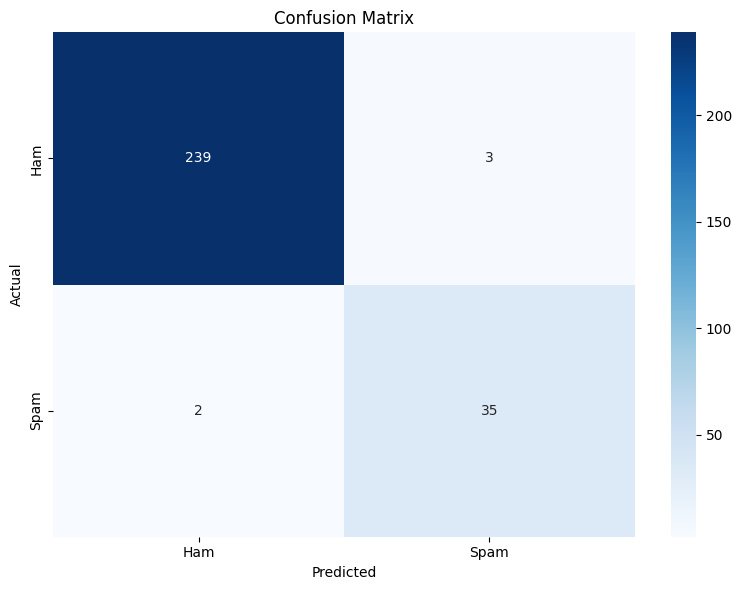

In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, confusion_matrix

# Load the best model
# model = LSTMModel(input_dim, hidden_dim, output_dim).cuda()
# model.load_state_dict(torch.load("MODEL_PTH"))

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_correct, total_samples = 0, 0
    all_test_labels, all_test_preds = [], []
    test_loss = 0

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.cuda(), labels.cuda()
            outputs = model(features)

            # Compute loss
            loss = criterion(outputs.squeeze(), labels.float())
            test_loss += loss.item()

            # Get predictions
            preds = torch.round(torch.sigmoid(outputs))

            # Count correct predictions
            test_correct += (preds.squeeze() == labels).sum().item()
            total_samples += labels.size(0)

            # Store labels and predictions
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())

    # Compute metrics
    accuracy = test_correct / total_samples * 100
    f1 = f1_score(all_test_labels, all_test_preds)
    precision = precision_score(all_test_labels, all_test_preds)
    conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

    # Display metrics
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test F1 Score: {f1:.2f}")
    print(f"Test Precision: {precision:.2f}")
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")

    # Display confusion matrix
    # print("Confusion Matrix:")
    # print(conf_matrix)

    # Enhanced confusion matrix visualization
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return accuracy, f1, precision

# Test the model
criterion = nn.BCEWithLogitsLoss()
accuracy, f1, precision = evaluate_model(model, test_loader, criterion)


# **_Saving the Model_**


In [23]:
MODEL_PTH = "/kaggle/working/lstm_model"
torch.save(model.state_dict(), MODEL_PTH)

print("Model has been saved\n")

Model has been saved

